In [1]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 646 kB 7.8 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 


In [2]:
import graphlearning as gl
import numpy as np
from scipy import sparse, linalg 
from scipy.special import softmax
from sklearn.decomposition import PCA as sklearn_pca
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Active learning Methods

In [5]:
import graphlearning as gl
import numpy as np
from scipy import sparse, linalg
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt

In [6]:
#Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50)
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [7]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #GSSL
  u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
  pred_labels = np.argmax(u, axis=1)
  pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

  #Output results
  if plot is True: 
    scatterplot(data, labels, train_ind, [], pred_labels, algorithm) 
  print('Number of Labels,Accuracy')
  print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

  return train_ind, pred_acc, u

In [8]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        values_per_class = obj_values[label_indices]/np.sum(obj_values[label_indices])
        new_train_ind = np.random.choice(label_indices, size=1, replace=False, p=values_per_class)
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [9]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

#VOPT paper uncertainty sampling
# def uncertainty(u, labeled_ind=None):
#   #u is num_pts x num_classes
#   num_pts = u.shape[0]
#   sorted = np.sort(u, axis=1)
#   obj_values = 1-(sorted[:,-1]-sorted[:,-2])
#   if labeled_ind is None:
#     return obj_values
#   else:
#     obj_values[labeled_ind] = obj_values.min()
#     return obj_values

#Kevin's uncertainty sampling
def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = uncertainty(u, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [10]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      C = K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
      print("negative diagonals:",np.sum(np.diag(C)<=0))
      print("negative entries:",np.sum(C<0))
      return C

#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)
    C = C[np.ix_(not_k, not_k)]
    print("negative diagonals:",np.sum(np.diag(C)<=0))
    print("negative entries:",np.sum(C<0))
    return C

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.5*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = v_opt(C, train_ind)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [11]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using sigma-opt
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.5*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = sigma_opt(C, train_ind)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [12]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using sigma-opt
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.5*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values, unc_values = mc_vopt(C, u, train_ind)
    stats(unc_values, 'mc_vopt') 
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [13]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using sigma-opt
def mc_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Model Change")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.5*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values, unc_values = model_change(C, u, train_ind)
    stats(unc_values, 'model_change') 
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [14]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sopt_acc, mc_acc, mcvopt_acc, algorithm, filename=None):
  plt.figure(figsize=(12, 8), dpi=100)
  matplotlib.rcParams.update({'font.size': 16})
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  plt.plot(num_train, mc_acc, 'yo-', markersize=10, label='Model Change')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%algorithm)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sopt_acc.max(), "mc: %.3f"%mc_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

In [15]:
#Function to plot the selected points and the objective function values
def scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    matplotlib.rcParams.update({'font.size': 12})
    
    ##FIRST PLOT
    #plot the labeled and unlabeled points
    ax1.set_title('Active Learning Selection')
    ax1.scatter(data[:, 0], data[:, 1], c=labels, s=25, alpha=0.3)
    ax1.scatter(data[train_ind, 0], data[train_ind, 1], c='r')

    ##SECOND PLOT
    #plot the objective function values
    #lowest = darkest (dark blue)
    #highest = brightest (yellow)
    ax2.set_title("Objective Values")
    ax2.scatter(data[:, 0], data[:, 1], c=obj_values, alpha=0.5)
##    plt.savefig(str(len(train_ind))+' labels.png')

    ##THIRD PLOT
    ax3.set_title("%s Classification"%algorithm)
    ax3.scatter(data[:, 0], data[:, 1], c=pred_labels, s=25, alpha=0.3)
    plt.show()

In [16]:
def active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  num_train, rand = random_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, unc = uncertainty_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, vopt = vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, sopt = sigmaopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, mc = mc_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, mc_vopt = mc_vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  lineplot(num_train, rand, unc, vopt, sopt, mc, mc_vopt, algorithm, filename='%s_%sAL_Results'%(algorithm,method))
  return num_train, rand, unc, vopt, sopt, mc, mc_vopt

In [17]:
def average_trials(num_trials, W, labels, num_train_per_class, num_labels, algorithm, method):
  random = np.random.choice(9999, size=num_trials, replace=False)
  num_train, rand, unc, vopt, sopt, mc, mc_vopt = active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random[0])
  for i in range(1,num_trials):
    _, rand1, unc1, vopt1, sopt1, mc1, mc_vopt1 = active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random[i])
    rand += rand1
    unc += unc1
    vopt += vopt1
    sopt += sopt1
    mc += mc1
    mc_vopt += mc_vopt1
  rand = np.divide(rand,num_trials)
  unc = np.divide(unc,num_trials)
  vopt = np.divide(vopt,num_trials)
  sopt = np.divide(sopt,num_trials)
  mc = np.divide(mc,num_trials)
  mc_vopt = np.divide(mc_vopt,num_trials)
  lineplot(num_train, rand, unc, vopt, sopt, mc, mc_vopt, algorithm, filename="%s_AL_%d_Average_Trials"%(algorithm, num_trials))
  return num_train, rand, unc, vopt, sopt, mc, mc_vopt

#Active learning on MNIST

In [ ]:
#Function to perform PCA on image
def PCA(data, component=False):

  #Perform PCA with 1200 components
  pca = sklearn_pca(n_components=data.shape[1]//2)
  pca.fit(data)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_data = pca.fit_transform(data)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  print("shape:",pca_data.shape)
  
  if component==True:
    return pca_data, num_components
  return pca_data

In [3]:
#Load labels, knndata, an build 10-nearest neighbor weight matrix
data = gl.load_dataset('mnist')
data = np.vstack((data[:1000], data[-1000:]))
labels = gl.load_labels('mnist')
labels = np.hstack([labels[:1000],labels[-1000:]])

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (2000, 2000)
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,69.749
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,69.834
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,69.819
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,69.804
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,71.249
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,71.587
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,69.405
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,69.289
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,71.645
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,72.539
0.0 0.0005047955577990

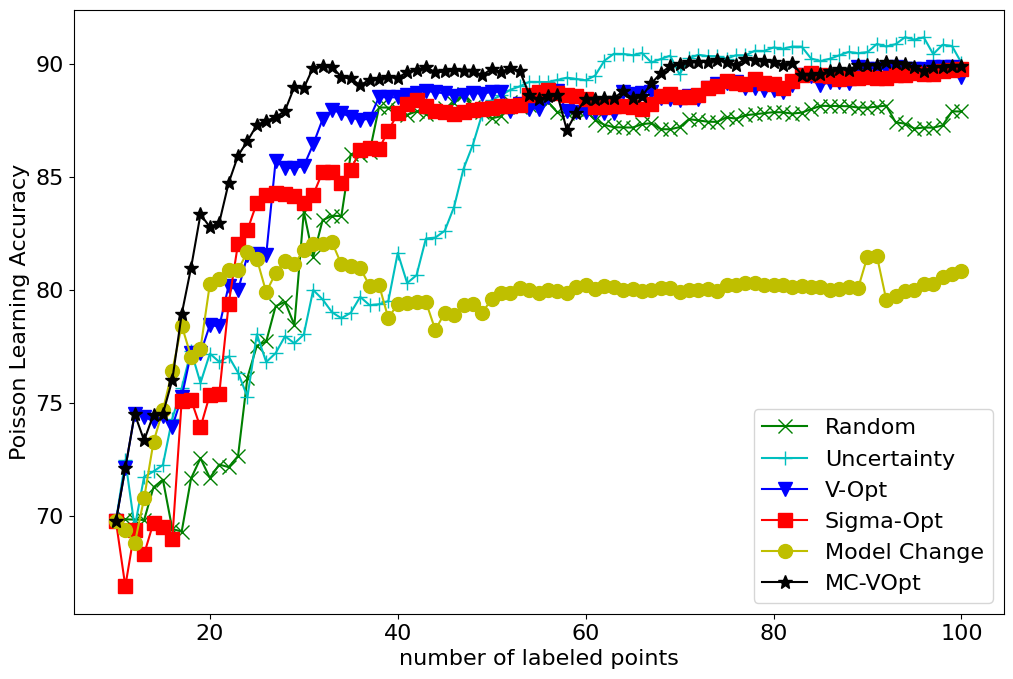

rand: 88.684 unc: 91.186 vopt: 89.879 sopt: 89.789 mc: 82.105 mc-vopt: 90.224
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,64.975
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,71.292
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,70.976
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,74.233
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,74.220
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,74.912
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,76.210
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,77.105
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,77.195
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,77.234
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,77.323
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,77.211
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

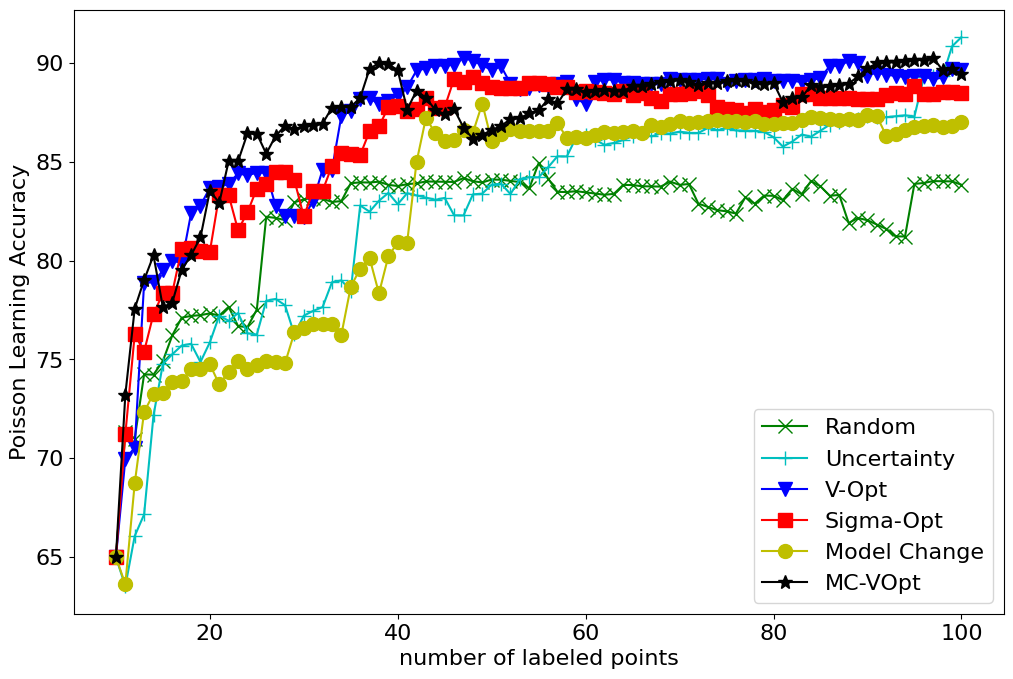

rand: 84.936 unc: 91.316 vopt: 90.271 sopt: 89.293 mc: 87.955 mc-vopt: 90.279
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,65.126
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,65.510
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,73.340
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,76.246
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,76.284
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,76.625
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,78.427
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,81.947
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,83.653
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,83.039
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,82.879
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,82.668
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

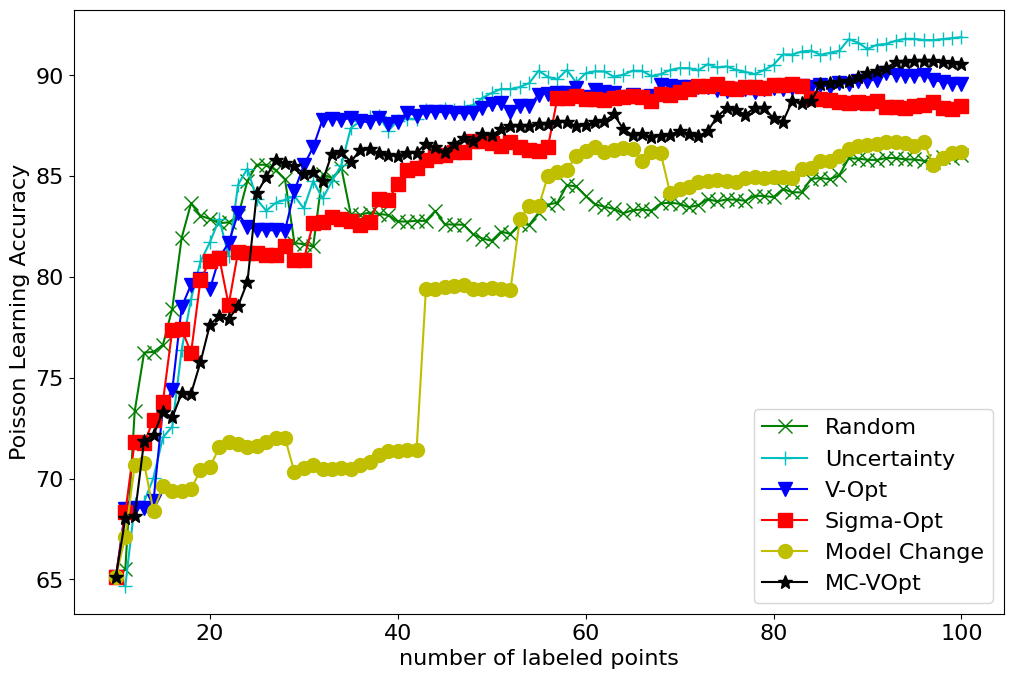

rand: 86.053 unc: 91.895 vopt: 90.094 sopt: 89.572 mc: 86.712 mc-vopt: 90.709
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,72.312
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,71.041
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,72.535
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,72.370
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,73.515
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,74.106
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,72.833
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,73.979
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,74.470
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,74.760
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,74.697
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,74.684
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

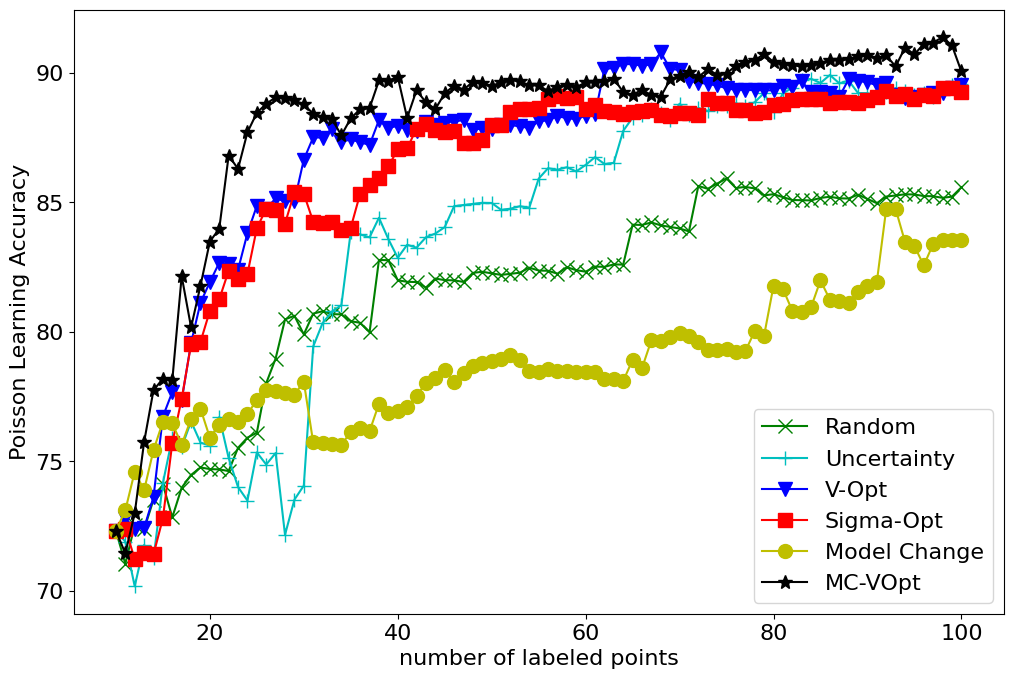

rand: 85.922 unc: 89.916 vopt: 90.787 sopt: 89.432 mc: 84.748 mc-vopt: 91.377
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,69.095
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,69.080
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,70.171
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,69.401
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,69.587
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,69.521
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,72.732
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,72.970
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,72.856
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,74.508
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,76.667
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,75.897
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

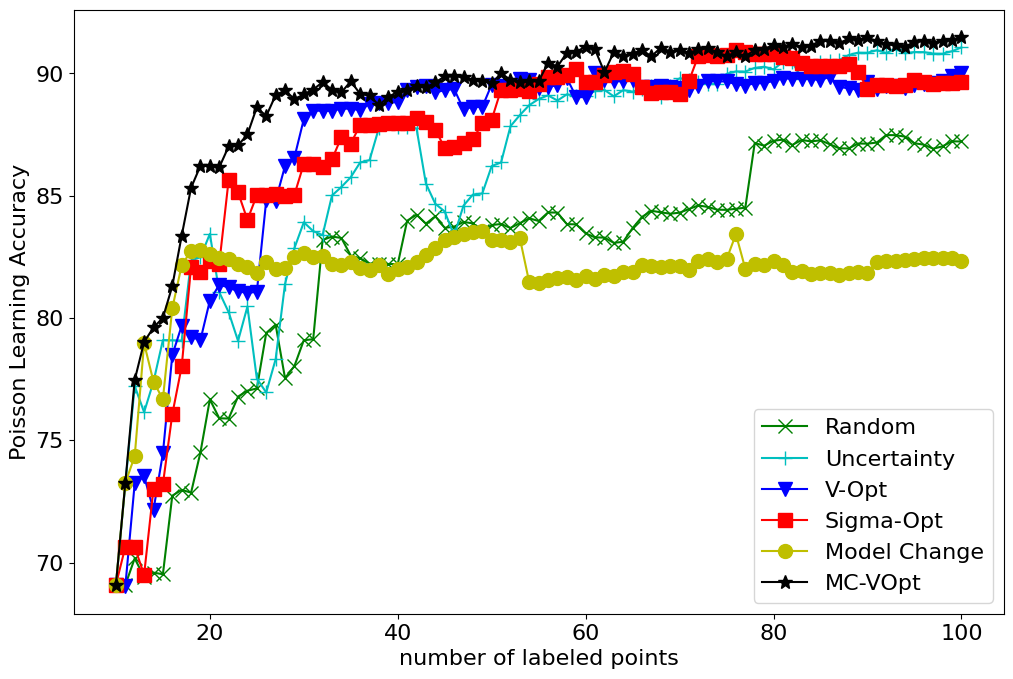

rand: 87.474 unc: 91.053 vopt: 90.000 sopt: 90.956 mc: 83.547 mc-vopt: 91.474
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,66.080
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,66.164
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,69.115
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,68.646
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,68.228
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,69.924
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,76.210
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,78.417
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,78.355
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,78.496
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,78.535
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,78.525
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

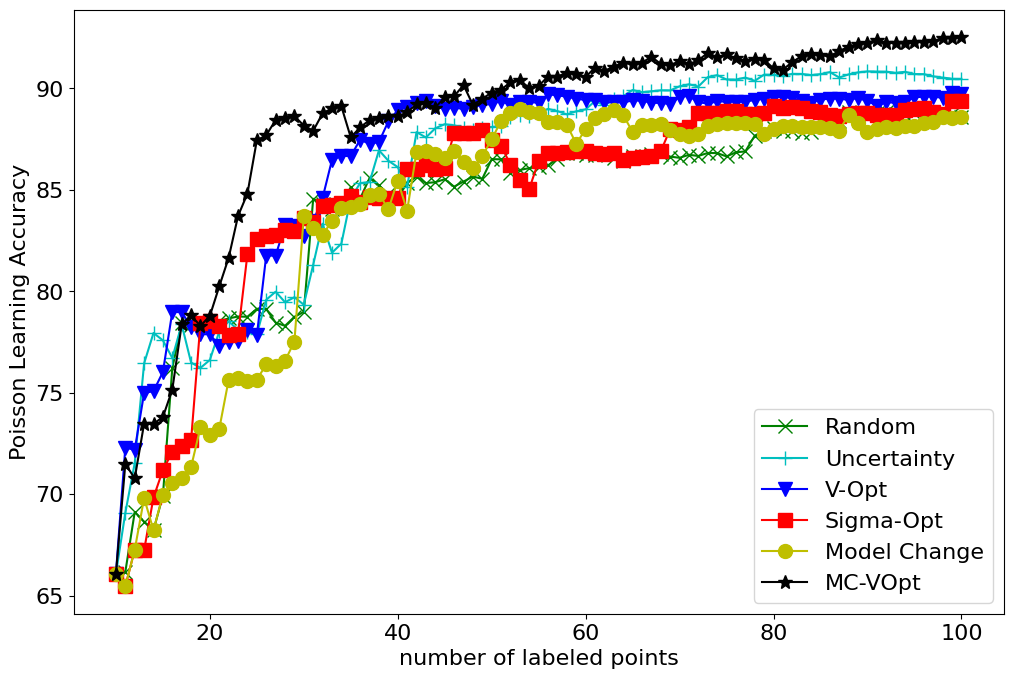

rand: 88.860 unc: 90.838 vopt: 89.795 sopt: 89.374 mc: 89.009 mc-vopt: 92.526
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,74.774
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,74.811
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,74.849
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,74.836
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,74.723
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,74.811
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,75.353
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,75.391
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,74.369
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,74.306
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,75.556
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,75.543
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

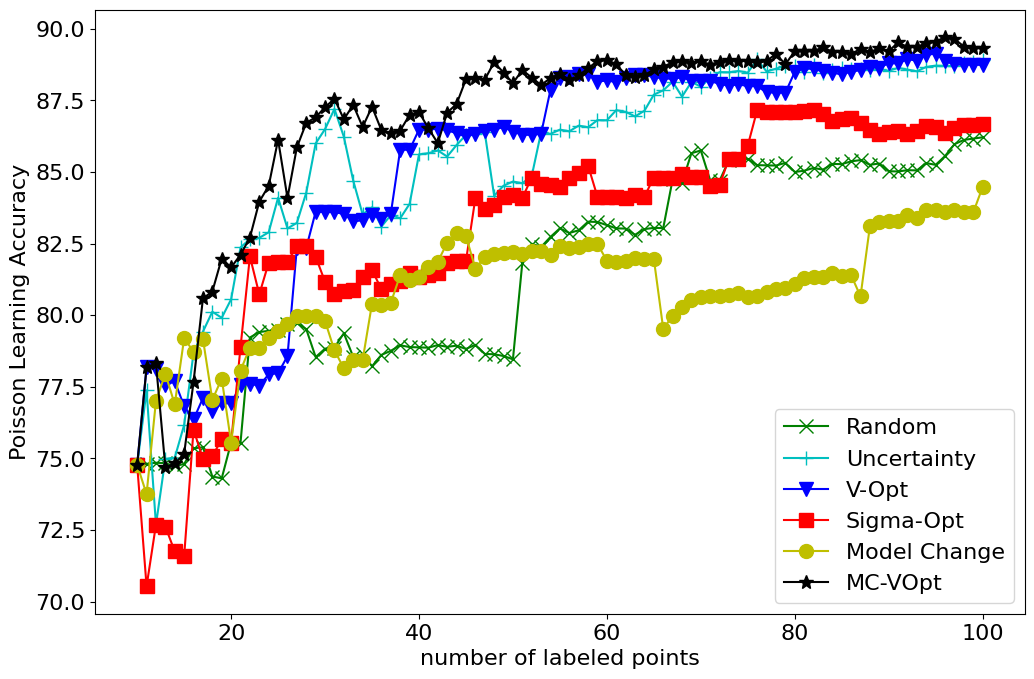

rand: 86.211 unc: 88.929 vopt: 89.134 sopt: 87.174 mc: 84.474 mc-vopt: 89.706
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,70.503
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,70.789
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,70.473
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,71.314
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,72.004
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,73.149
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,78.982
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,79.728
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,82.190
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,81.474
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,85.051
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,85.093
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

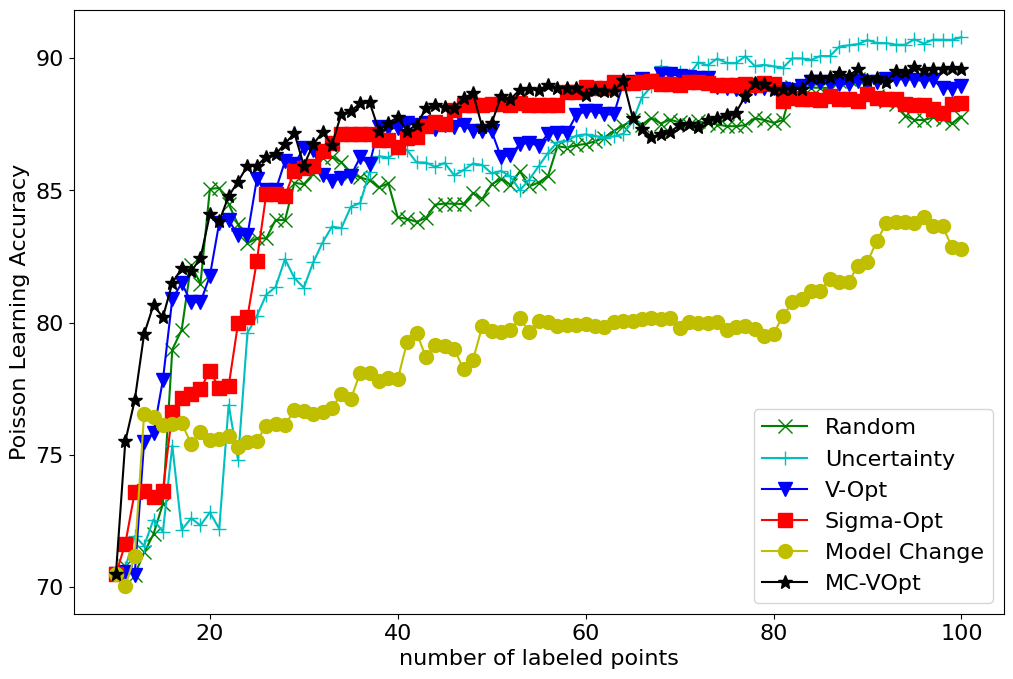

rand: 89.226 unc: 90.789 vopt: 89.389 sopt: 89.136 mc: 83.981 mc-vopt: 89.659
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,73.367
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,73.555
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,75.302
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,74.736
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,74.471
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,74.408
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,76.966
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,77.811
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,77.750
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,78.748
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,78.030
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,78.272
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

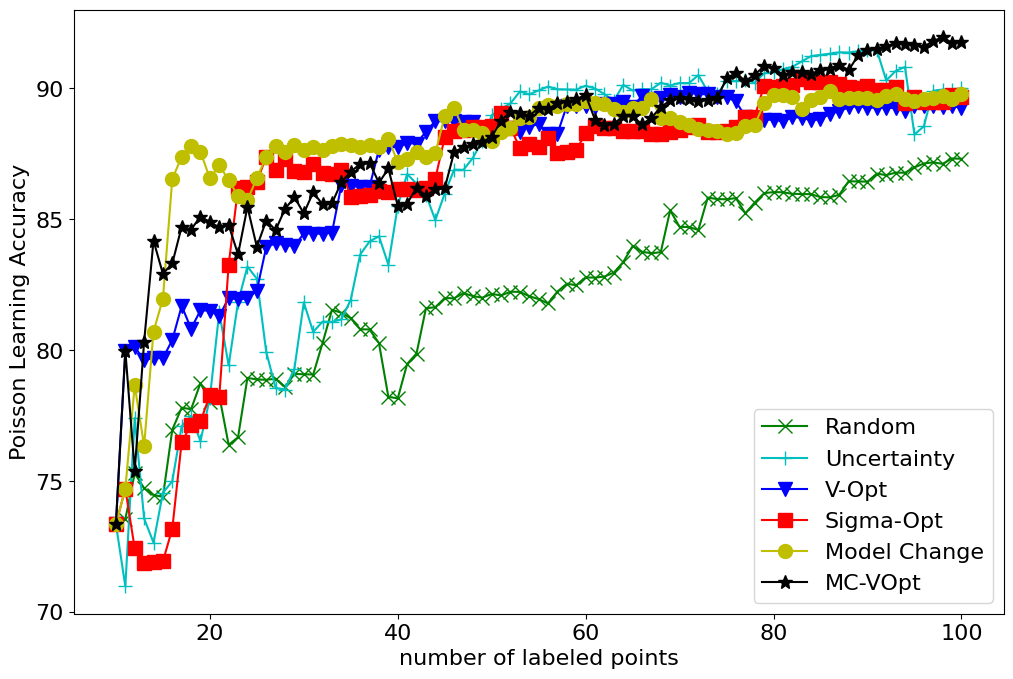

rand: 87.322 unc: 91.466 vopt: 89.839 sopt: 90.350 mc: 89.916 mc-vopt: 91.956
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Poisson: 10,59.548
0.0 0.0005025125628140704
Number of Labels,Accuracy
Poisson: 11,59.477
0.0 0.0005027652086475615
Number of Labels,Accuracy
Poisson: 12,60.161
0.0 0.0005030181086519115
Number of Labels,Accuracy
Poisson: 13,68.395
0.0 0.0005032712632108706
Number of Labels,Accuracy
Poisson: 14,67.925
0.0 0.0005035246727089627
Number of Labels,Accuracy
Poisson: 15,67.909
0.0 0.0005037783375314861
Number of Labels,Accuracy
Poisson: 16,67.137
0.0 0.0005040322580645161
Number of Labels,Accuracy
Poisson: 17,67.070
0.0 0.0005042864346949068
Number of Labels,Accuracy
Poisson: 18,66.751
0.0 0.0005045408678102926
Number of Labels,Accuracy
Poisson: 19,66.734
0.0 0.0005047955577990914
Number of Labels,Accuracy
Poisson: 20,66.515
0.0 0.000505050505050505
Number of Labels,Accuracy
Poisson: 21,68.317
0.0 0.0005053057099545225
Number of Labels,Accuracy
Poiss

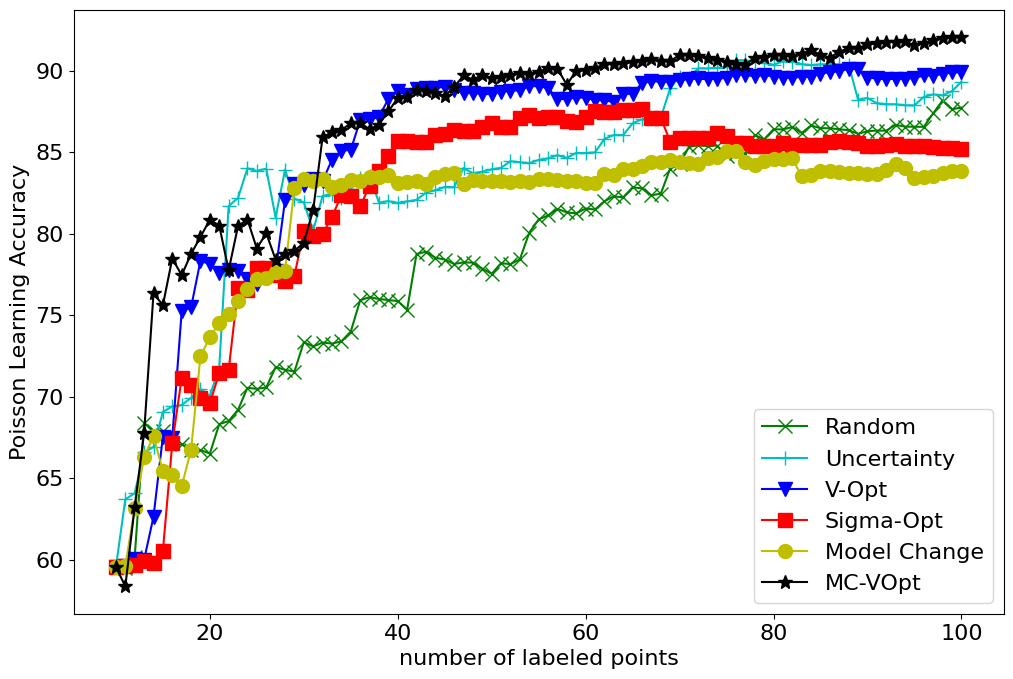

rand: 88.170 unc: 90.644 vopt: 90.115 sopt: 87.642 mc: 85.091 mc-vopt: 92.057


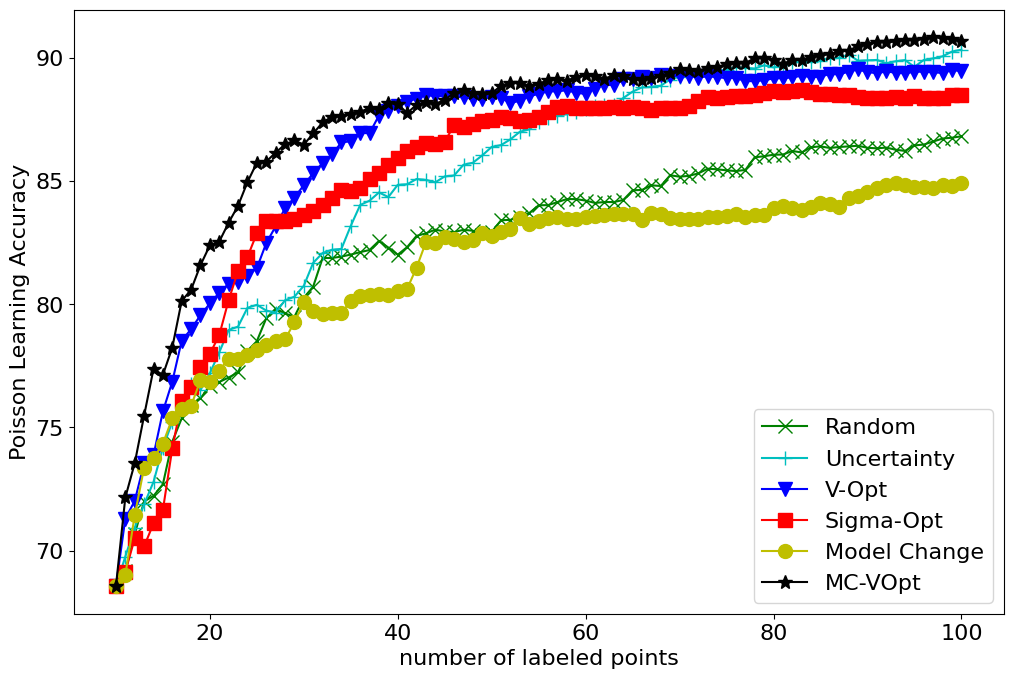

rand: 86.821 unc: 90.337 vopt: 89.534 sopt: 88.712 mc: 84.937 mc-vopt: 90.846


(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([68.55276382, 69.15535445, 70.67404427, 71.99798691, 72.22054381,
        72.69521411, 74.42540323, 75.37065053, 75.92330979, 76.18374558,
        76.69191919, 76.84689237, 77.0273003 , 77.23823976, 78.11234818,
        78.50126582, 79.43262411, 79.82260517, 79.62981744, 79.49264333,
        80.26395939, 80.72117826, 81.8800813 , 81.88103711, 81.93794507,
        82.02035623, 82.11812627, 82.20580744, 82.57390418, 82.30494646,
        82.01530612, 82.32261358, 82.77834525, 82

In [23]:
#Active Learning on Poisson Learning
W = weight_matrix(data)
average_trials(10, W, labels, 1, 100, 'Poisson', 'sequential')

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (2000, 2000)
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,57.940
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,29.361
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,29.477
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,31.555
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,38.671
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,34.509
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,40.675
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,41.906
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,49.243
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,41.444
0.0 0.0005047955577990

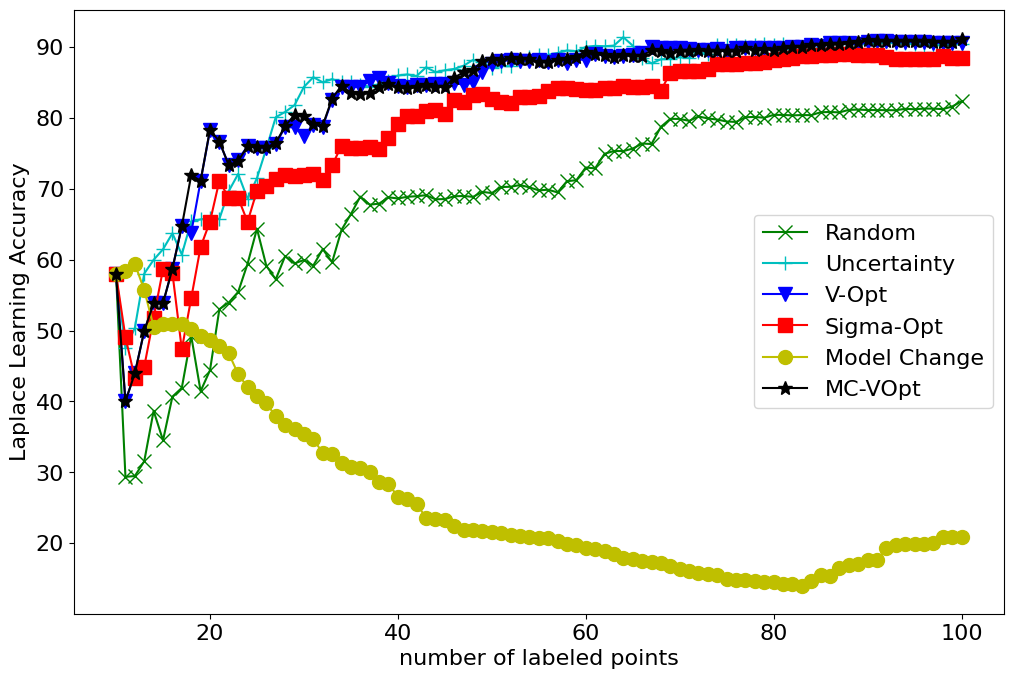

rand: 82.316 unc: 91.374 vopt: 90.833 sopt: 89.022 mc: 59.406 mc-vopt: 91.053
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,48.894
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,51.684
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,48.239
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,46.049
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,52.870
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,56.625
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,59.173
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,59.455
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,59.384
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,61.686
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,65.000
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,68.418
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

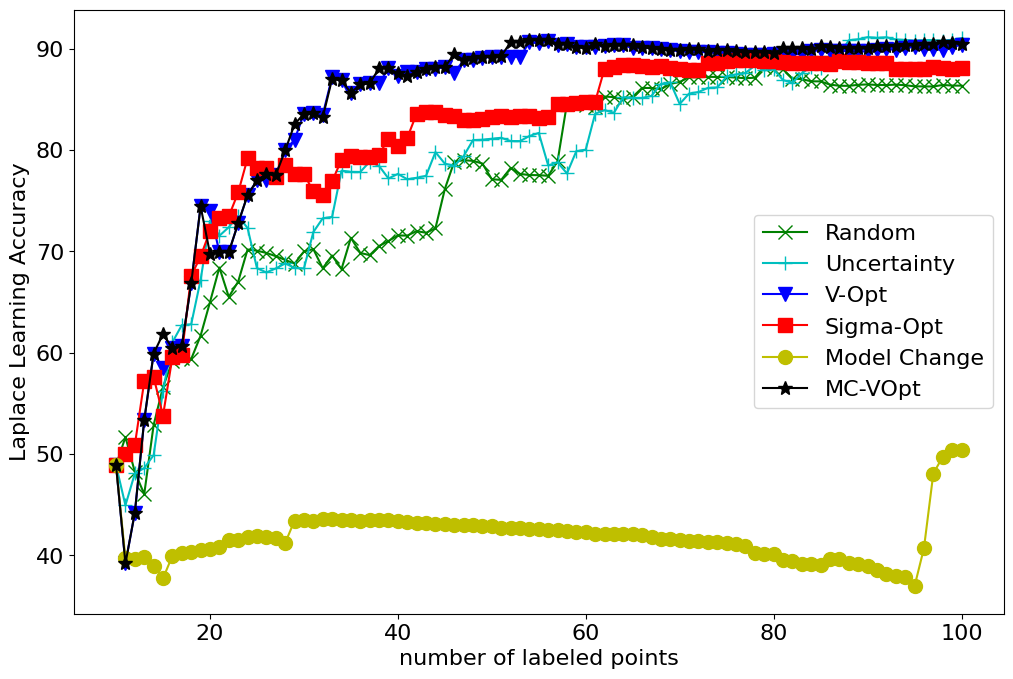

rand: 88.235 unc: 91.152 vopt: 90.792 sopt: 88.929 mc: 50.395 mc-vopt: 90.895
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,58.141
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,58.069
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,38.481
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,47.307
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,52.014
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,55.113
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,55.444
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,54.413
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,60.646
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,60.777
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,65.101
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,64.426
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

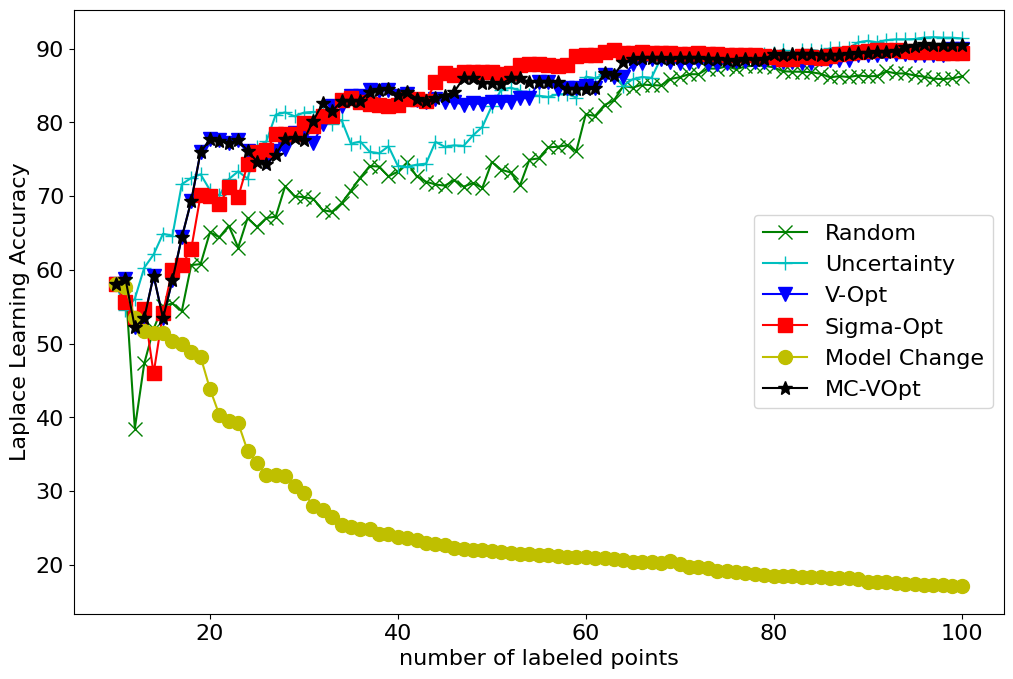

rand: 87.669 unc: 91.540 vopt: 89.900 sopt: 89.838 mc: 58.141 mc-vopt: 90.599
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,46.884
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,52.338
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,56.036
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,66.130
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,65.811
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,62.972
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,62.601
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,62.481
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,59.788
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,54.821
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,61.313
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,55.028
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

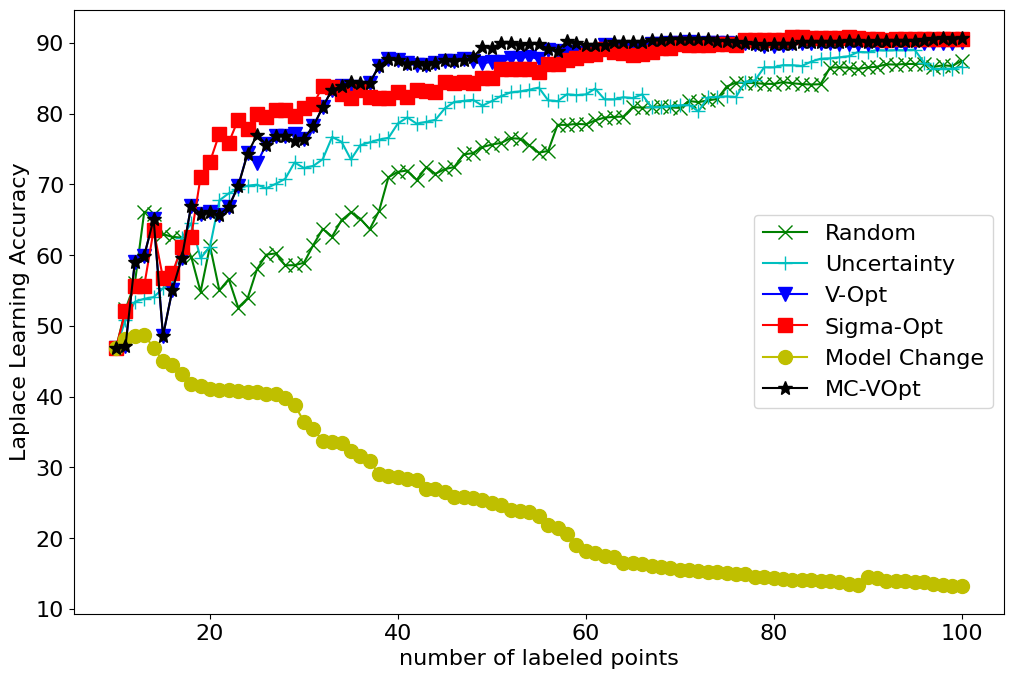

rand: 87.474 unc: 89.081 vopt: 90.211 sopt: 90.824 mc: 48.767 mc-vopt: 90.737
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,43.015
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,42.232
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,31.439
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,36.638
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,42.951
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,45.038
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,52.419
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,57.943
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,58.426
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,59.667
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,54.293
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,52.956
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

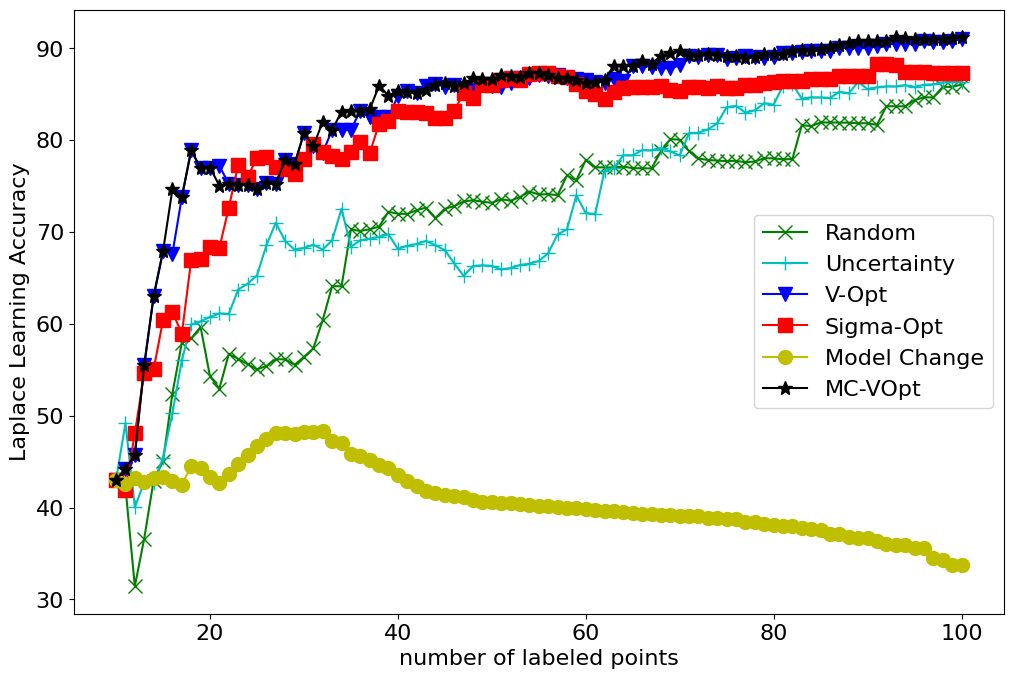

rand: 86.053 unc: 86.368 vopt: 91.000 sopt: 88.266 mc: 48.323 mc-vopt: 91.211
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,50.251
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,52.690
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,52.666
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,42.375
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,52.266
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,51.788
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,47.833
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,53.858
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,55.348
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,57.395
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,56.010
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,56.392
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

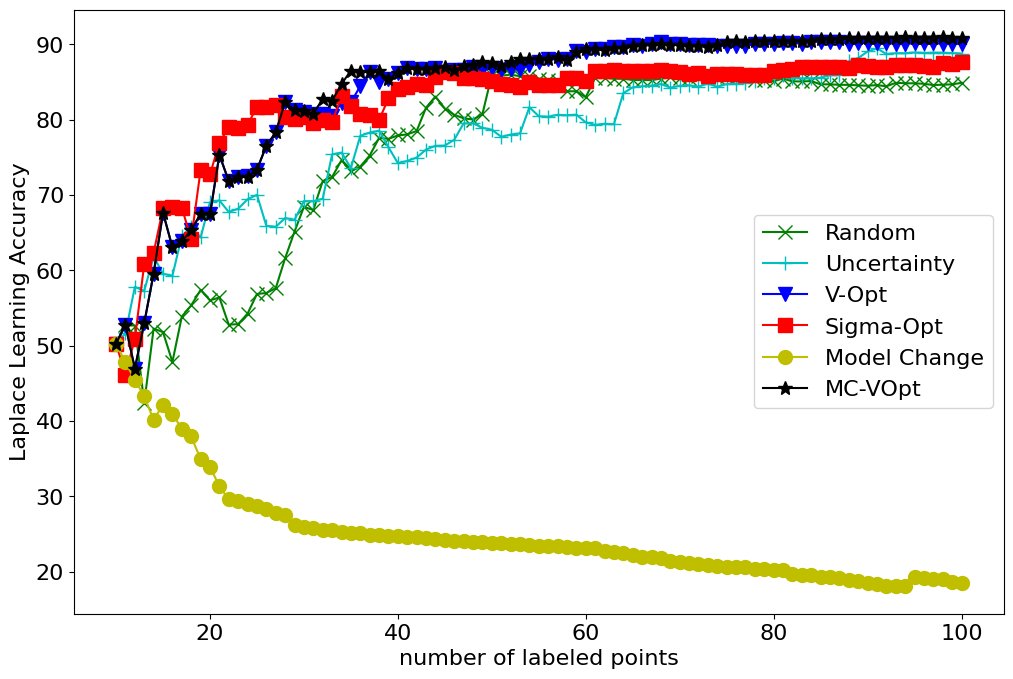

rand: 85.986 unc: 89.471 vopt: 90.344 sopt: 87.632 mc: 50.251 mc-vopt: 90.957
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,46.332
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,43.288
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,51.157
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,37.745
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,39.527
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,46.398
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,43.397
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,52.295
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,50.807
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,55.881
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,55.354
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,56.190
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

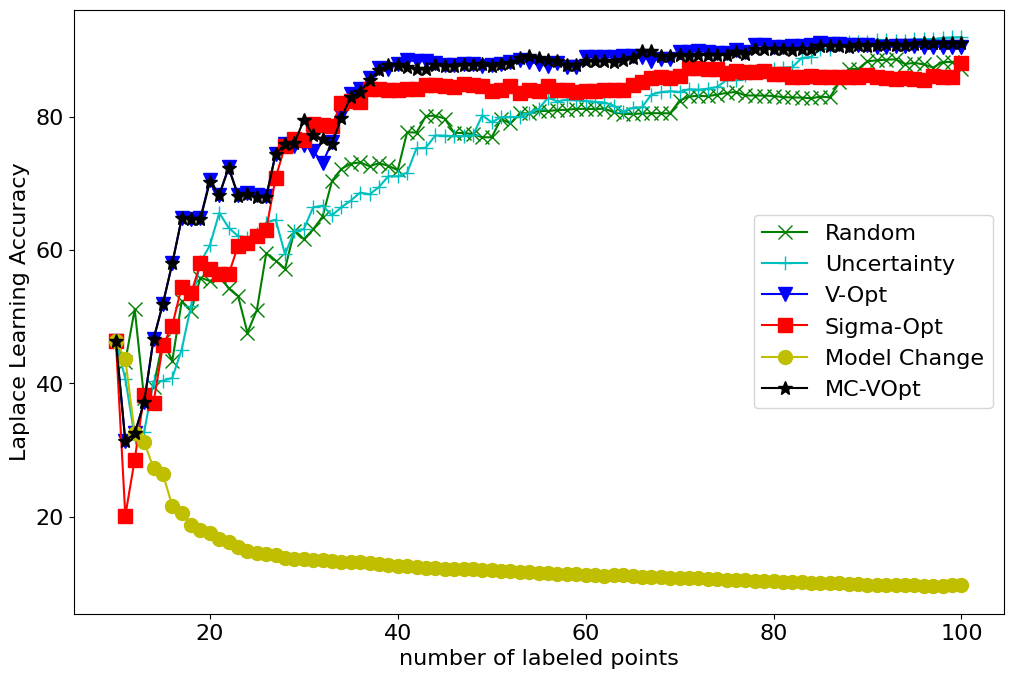

rand: 88.621 unc: 91.947 vopt: 91.123 sopt: 88.105 mc: 46.332 mc-vopt: 91.057
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,46.884
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,55.606
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,49.950
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,38.148
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,43.756
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,50.327
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,51.815
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,46.394
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,50.706
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,41.090
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,43.990
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,46.791
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

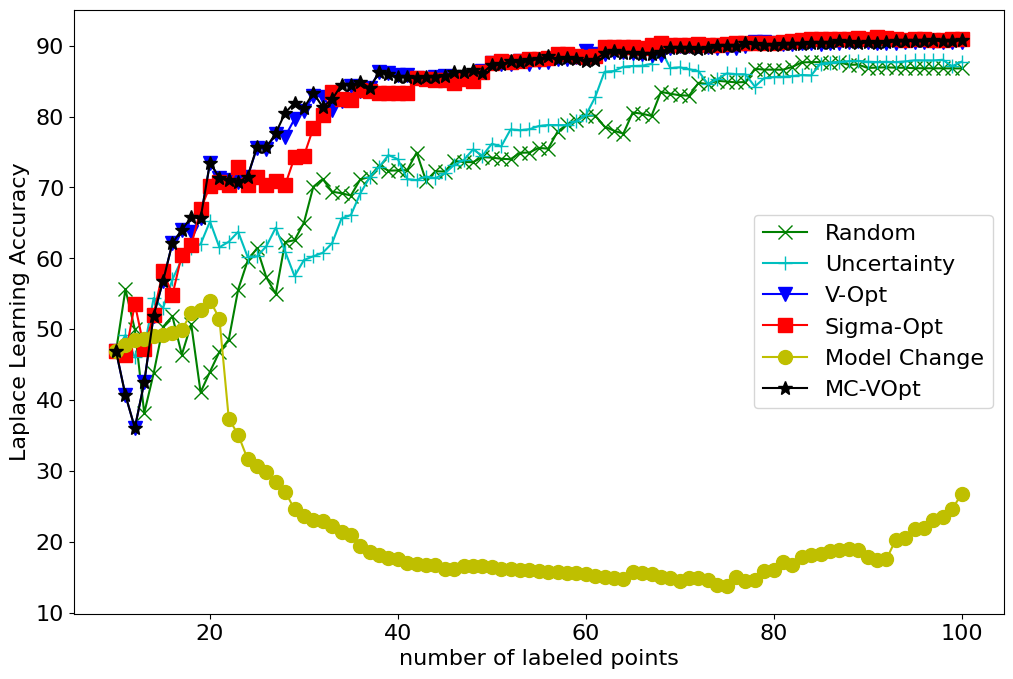

rand: 87.683 unc: 89.441 vopt: 90.633 sopt: 91.200 mc: 54.040 mc-vopt: 90.842
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,42.965
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,38.512
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,28.471
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,40.463
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,43.958
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,37.531
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,41.633
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,44.125
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,42.281
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,45.734
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,50.707
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,54.624
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

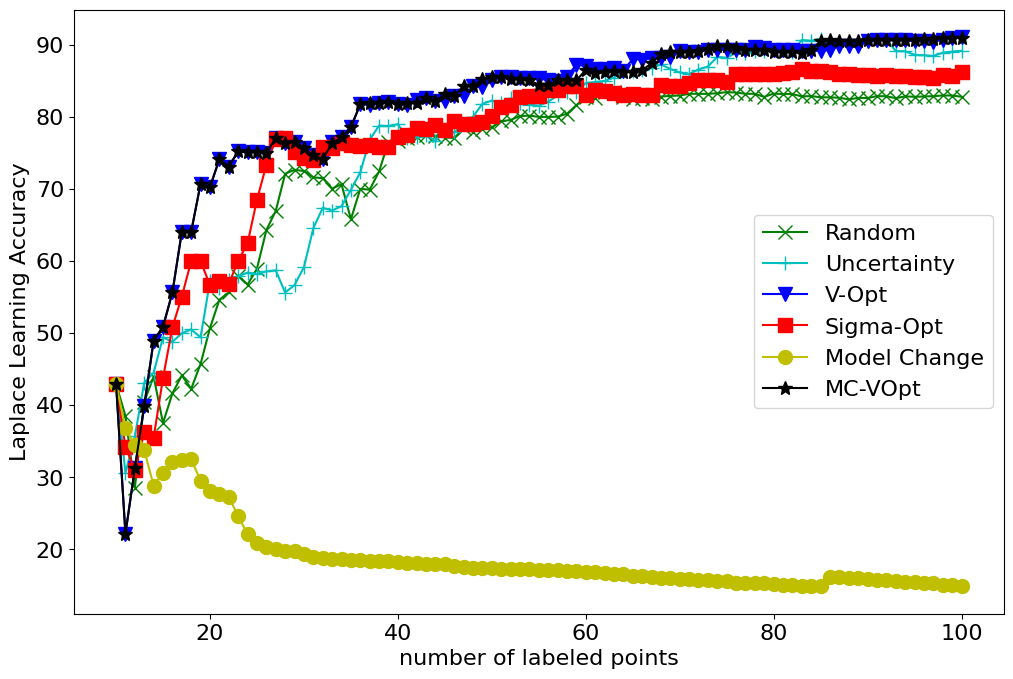

rand: 83.437 unc: 90.862 vopt: 91.053 sopt: 86.594 mc: 42.965 mc-vopt: 91.005
Random Sampling
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,61.960
0.0 0.0005025125628140704
Number of Labels,Accuracy
Laplace: 11,48.416
0.0 0.0005027652086475615
Number of Labels,Accuracy
Laplace: 12,53.924
0.0 0.0005030181086519115
Number of Labels,Accuracy
Laplace: 13,57.071
0.0 0.0005032712632108706
Number of Labels,Accuracy
Laplace: 14,56.042
0.0 0.0005035246727089627
Number of Labels,Accuracy
Laplace: 15,53.552
0.0 0.0005037783375314861
Number of Labels,Accuracy
Laplace: 16,56.048
0.0 0.0005040322580645161
Number of Labels,Accuracy
Laplace: 17,54.967
0.0 0.0005042864346949068
Number of Labels,Accuracy
Laplace: 18,60.242
0.0 0.0005045408678102926
Number of Labels,Accuracy
Laplace: 19,57.395
0.0 0.0005047955577990914
Number of Labels,Accuracy
Laplace: 20,59.444
0.0 0.000505050505050505
Number of Labels,Accuracy
Laplace: 21,58.110
0.0 0.0005053057099545225
Number of Labels,Accuracy
Lapla

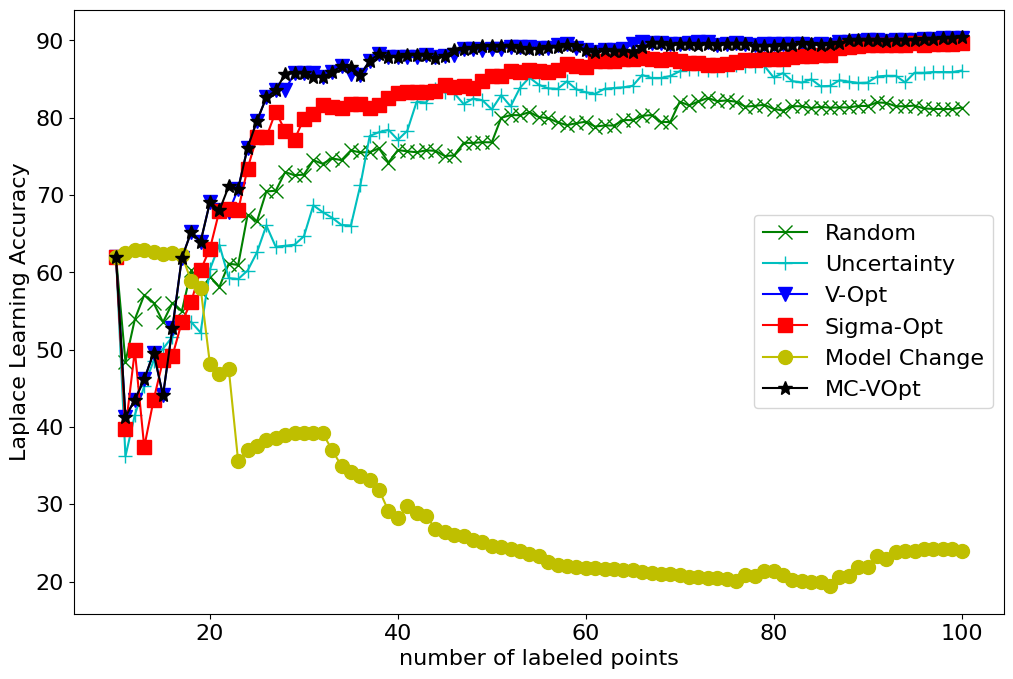

rand: 82.564 unc: 86.850 vopt: 90.368 sopt: 89.684 mc: 62.877 mc-vopt: 90.421


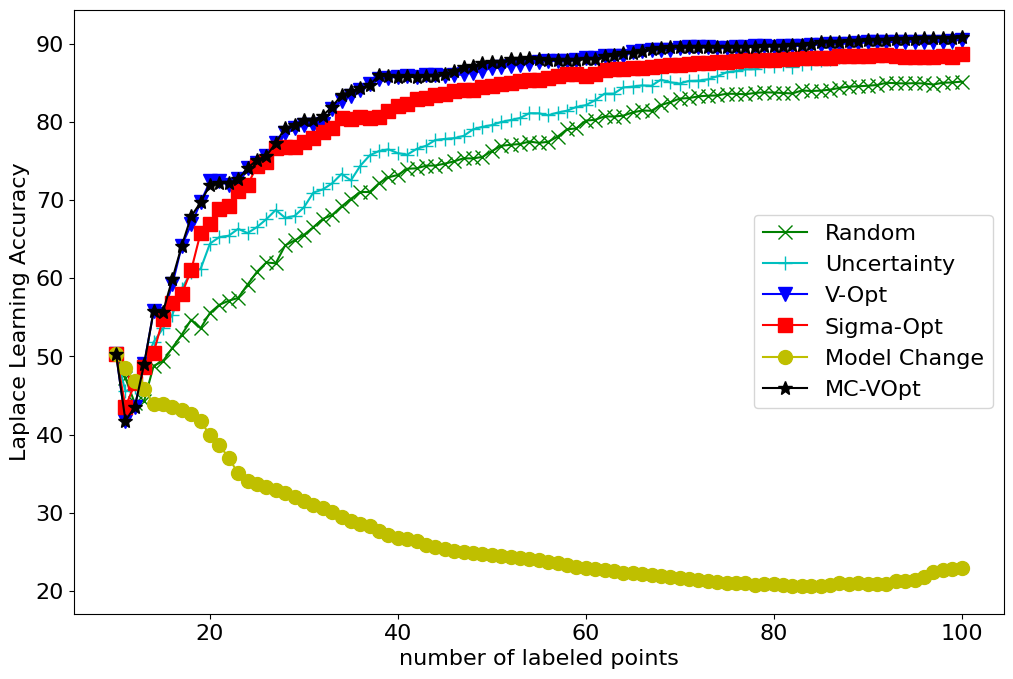

rand: 85.132 unc: 89.204 vopt: 90.453 sopt: 88.637 mc: 50.327 mc-vopt: 90.816


(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([50.32663317, 47.2197084 , 43.98390342, 44.34826371, 48.78650554,
        49.38539043, 51.10383065, 52.78366112, 54.68718466, 53.58909642,
        55.56060606, 56.59423951, 57.1132457 , 57.4759737 , 59.17510121,
        60.81012658, 62.00607903, 61.89559047, 64.18864097, 64.81988838,
        65.53299492, 66.51599797, 67.56605691, 68.07829181, 69.16581892,
        70.13740458, 71.01323829, 71.0188487 , 72.14576962, 72.89648139,
        73.19897959, 73.98672792, 74.05005107, 74

In [24]:
#Active Learning on Laplace Learning
W = weight_matrix(data)
average_trials(10, W, labels, 1, 100, 'Laplace', 'sequential')